In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import os
import librosa
import nltk
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print("Setup complete. Ready to preprocess the data!")

Setup complete. Ready to preprocess the data!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajt8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajt8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajt8\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rajt8\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Paths to MELD dataset
meld_train_path = r'datasets\raw\MELD\train\train_sent_emo.csv'
meld_dev_path = r'datasets\raw\MELD\dev_sent_emo.csv'
meld_test_path = r'datasets\raw\MELD\test_sent_emo.csv'

# Load datasets
train_df = pd.read_csv(meld_train_path)
dev_df = pd.read_csv(meld_dev_path)
test_df = pd.read_csv(meld_test_path)

# Combine datasets for preprocessing
meld_data = pd.concat([train_df, dev_df, test_df], ignore_index=True)

# Display basic info
print("Dataset loaded successfully!")
print(meld_data.info())


Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        13708 non-null  int64 
 1   Utterance     13708 non-null  object
 2   Speaker       13708 non-null  object
 3   Emotion       13708 non-null  object
 4   Sentiment     13708 non-null  object
 5   Dialogue_ID   13708 non-null  int64 
 6   Utterance_ID  13708 non-null  int64 
 7   Season        13708 non-null  int64 
 8   Episode       13708 non-null  int64 
 9   StartTime     13708 non-null  object
 10  EndTime       13708 non-null  object
dtypes: int64(5), object(6)
memory usage: 1.2+ MB
None


In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Initialize stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Text preprocessing function
def preprocess_text(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return ' '.join(tokens)

# Apply preprocessing to the utterances
meld_data['Clean_Utterance'] = meld_data['Utterance'].apply(preprocess_text)

# Display sample processed text
print("\nSample Processed Utterances:")
print(meld_data[['Utterance', 'Clean_Utterance']].head())


Sample Processed Utterances:
                                           Utterance  \
0  also I was the point person on my companys tr...   
1                   You mustve had your hands full.   
2                            That I did. That I did.   
3      So lets talk a little bit about your duties.   
4                             My duties?  All right.   

                                     Clean_Utterance  
0  also point person companys transition kl-5 gr...  
1                                 mustve hands full  
2                                                     
3                       lets talk little bit duties  
4                                       duties right  


In [4]:
# Enhanced text preprocessing function
def preprocess_text_v2(text):
    # Replace encoding artifacts
    text = text.replace("", "'")  # Normalize apostrophes
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return ' '.join(tokens)

# Apply refined preprocessing
meld_data['Clean_Utterance'] = meld_data['Utterance'].apply(preprocess_text_v2)

# Drop rows where Clean_Utterance is empty
meld_data = meld_data[meld_data['Clean_Utterance'] != '']

# Display updated samples
print("\nUpdated Sample Processed Utterances:")
print(meld_data[['Utterance', 'Clean_Utterance']].head())


Updated Sample Processed Utterances:
                                           Utterance  \
0  also I was the point person on my companys tr...   
1                   You mustve had your hands full.   
3      So lets talk a little bit about your duties.   
4                             My duties?  All right.   
5  Now youll be heading a whole division, so you...   

                                     Clean_Utterance  
0  also point person company 's transition kl-5 g...  
1                                must 've hands full  
3                      let 's talk little bit duties  
4                                       duties right  
5          'll heading whole division 'll lot duties  


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Extract features
meld_data['Word_Count'] = meld_data['Clean_Utterance'].apply(lambda x: len(x.split()))
meld_data['Char_Count'] = meld_data['Clean_Utterance'].apply(len)
meld_data['Sentiment_Polarity'] = meld_data['Clean_Utterance'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Display sample features
print("\nSample Features Extracted from Text:")
print(meld_data[['Clean_Utterance', 'Word_Count', 'Char_Count', 'Sentiment_Polarity']].head())


Sample Features Extracted from Text:
                                     Clean_Utterance  Word_Count  Char_Count  \
0  also point person company 's transition kl-5 g...           9          56   
1                                must 've hands full           4          19   
3                      let 's talk little bit duties           6          29   
4                                       duties right           2          12   
5          'll heading whole division 'll lot duties           7          41   

   Sentiment_Polarity  
0                 0.0  
1                 0.0  
3                 0.0  
4                 0.0  
5                 0.0  


In [6]:
# Calculate sentiment polarity from the original utterance
meld_data['Sentiment_Polarity'] = meld_data['Utterance'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Display updated sample features
print("\nUpdated Sentiment Polarity:")
print(meld_data[['Utterance', 'Sentiment_Polarity']].head())


Updated Sentiment Polarity:
                                           Utterance  Sentiment_Polarity
0  also I was the point person on my companys tr...                 0.0
1                   You mustve had your hands full.                 0.0
3      So lets talk a little bit about your duties.                 0.0
4                             My duties?  All right.                 0.0
5  Now youll be heading a whole division, so you...                 0.0


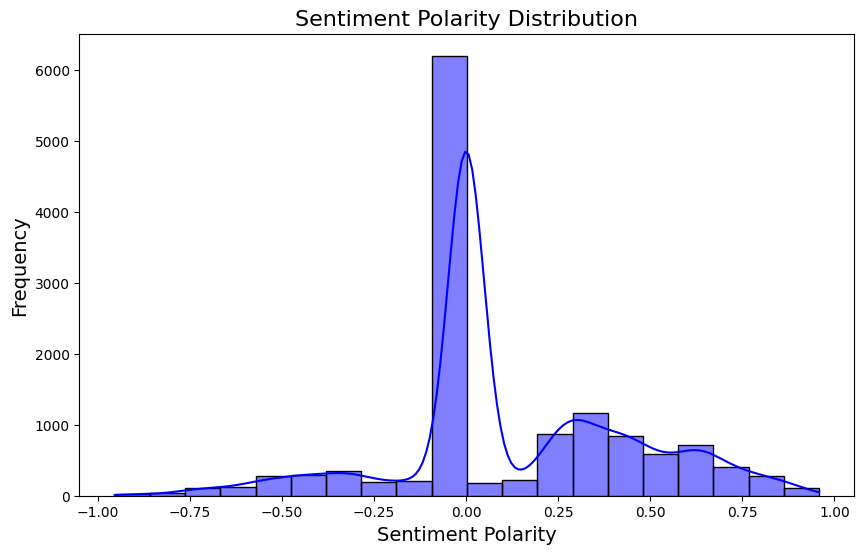

In [7]:
# Plot sentiment polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(meld_data['Sentiment_Polarity'], bins=20, kde=True, color='blue')
plt.title('Sentiment Polarity Distribution', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
# List all available audio files in the directory
available_files = set(os.listdir(audio_dir))

# Filter dataset to include only rows with matching audio files
meld_data = meld_data[meld_data['Audio_File'].isin(available_files)]

# Function to extract audio duration
def get_audio_duration(file_name):
    file_path = os.path.join(audio_dir, file_name)
    try:
        y, sr = librosa.load(file_path, sr=None)  
        return librosa.get_duration(y=y, sr=sr)  
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

# Update file mapping to include Utterance_ID
meld_data['Audio_File'] = meld_data.apply(lambda row: f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.wav", axis=1)

# Reapply audio duration extraction
meld_data['Audio_Duration'] = meld_data['Audio_File'].apply(get_audio_duration)

# Display sample audio durations
print("\nSample Audio Durations with Updated Mapping:")
print(meld_data[['Dialogue_ID', 'Utterance_ID', 'Audio_File', 'Audio_Duration']].head())


Sample Audio Durations with Updated Mapping:
   Dialogue_ID  Utterance_ID     Audio_File  Audio_Duration
0            0             0  dia0_utt0.wav        5.674667
1            0             1  dia0_utt1.wav        1.472000
3            0             3  dia0_utt3.wav        2.773333
4            0             4  dia0_utt4.wav        6.485333
5            0             5  dia0_utt5.wav        3.221333


In [20]:
# Function to extract MFCCs from audio
def get_mfcc_features(file_name):
    file_path = os.path.join(audio_dir, file_name)
    if not os.path.exists(file_path):  # Handle missing files
        return None
    try:
        y, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
        return mfccs.mean(axis=1).tolist()  # Return mean of each MFCC dimension
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

# Apply MFCC extraction
meld_data['MFCCs'] = meld_data['Audio_File'].apply(get_mfcc_features)

# Display sample MFCC features
print("\nSample MFCC Features:")
print(meld_data[['Dialogue_ID', 'Utterance_ID', 'Audio_File', 'MFCCs']].head())


Sample MFCC Features:
   Dialogue_ID  Utterance_ID     Audio_File  \
0            0             0  dia0_utt0.wav   
1            0             1  dia0_utt1.wav   
3            0             3  dia0_utt3.wav   
4            0             4  dia0_utt4.wav   
5            0             5  dia0_utt5.wav   

                                               MFCCs  
0  [-200.79408264160156, 65.95580291748047, 3.057...  
1  [-223.96542358398438, 76.85250091552734, 15.32...  
3  [-244.4572296142578, 57.01353073120117, 9.1649...  
4  [-185.72329711914062, 87.59825897216797, -46.9...  
5  [-251.8509063720703, 71.70755767822266, 3.9830...  


In [22]:
# Drop unnecessary columns if needed
final_features = meld_data[['Dialogue_ID', 'Utterance_ID', 'Emotion', 'Word_Count', 'Char_Count', 
                            'Sentiment_Polarity', 'Audio_Duration', 'MFCCs']]

# Save the dataset to a CSV file
processed_path = r'datasets\processed\meld_features.csv'
final_features.to_csv(processed_path, index=False)

print(f"Processed dataset saved to {processed_path}!")

Processed dataset saved to datasets\processed\meld_features.csv!


In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(final_features, test_size=0.3, random_state=42, stratify=final_features['Emotion'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Emotion'])

# Display the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 8287
Validation set size: 1776
Test set size: 1776
